# PyTorch for Computer Vision<br/>Example 1 - Convolutional Bebezal Network

**After this notebook, you'll be able to:**
- Use a folder with labels as subfolders as a dataset
- Split train dataset into train, test and val datasets
- Apply transformations in images for data augmentation
- Create a Convolutional Neural Network
- Train and validate your Convolutional Neural Network
- Analyze metrics obtained in training task
- Run inference in test dataset

**TO DO**
- Detect faces in a image, using another CNN
- Train and validate, using only face detected

Let's start ... Importing libraries ...

In [500]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms

from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import inspect
import time
import os
import copy

In [501]:
# check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## 1. Loading and Preparing Data

- Defining a Transform Pipeline
- Use a image folder as dataset
- Create Loader for Train, Val and Test Sets
- Visualize some samples

In [502]:
# Create a transform pipeline (Compose)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize(size=(99,99)),
    transforms.RandomCrop(size=(96,96)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [503]:
# Loader parameters
batch_size = 6
num_workers = 0

In [504]:
# Get image dataset
train_data = datasets.ImageFolder('../dataset', transform=transform)
print(train_data)

Dataset ImageFolder
    Number of datapoints: 30
    Root location: ../dataset
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-15, 15), resample=False, expand=False)
               Resize(size=(99, 99), interpolation=PIL.Image.BILINEAR)
               RandomCrop(size=(96, 96), padding=None)
               Grayscale(num_output_channels=3)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [505]:
# Create Train, Validation and Test DataSet
slices = (int(0.6 * len(train_data)), int(0.2 * len(train_data)), int(0.2 * len(train_data)))

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(train_data, slices)

train_idx = list(range(len(train_dataset)))
val_idx = list(range(len(val_dataset)))
test_idx = list(range(len(test_dataset)))

In [506]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [507]:
# Create Loaders for Train, Validation and Test Datasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

In [508]:
# Print Dataset Stats
print('# training images: ', len(train_sampler))
print('# validation images: ', len(valid_sampler))
print('# test images: ', len(test_sampler))
print('Classes: ', train_data.classes)

# training images:  18
# validation images:  6
# test images:  6
Classes:  ['alegre', 'brabo', 'sonado']


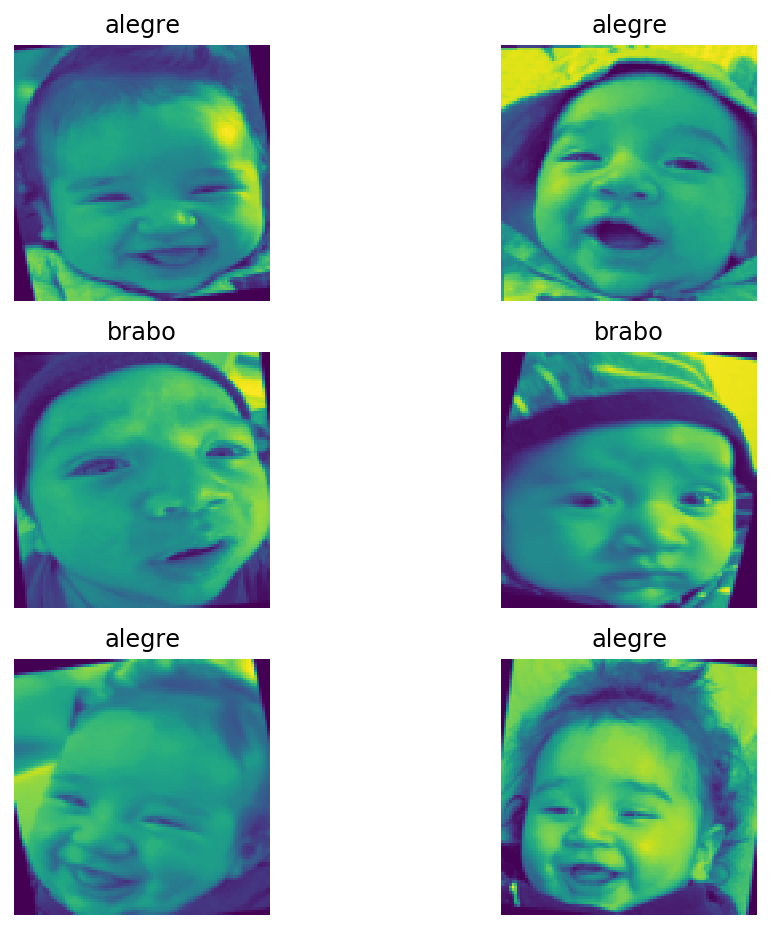

In [509]:
# Visualize Some sample data

# Obtaning first batch of training images, through iterator of DataLoader
dataiter = iter(train_loader)
images, labels = dataiter.next()

labels_map = {0 : 'alegre', 1 : 'brabo', 2 : 'sonado'};

fig = plt.figure(figsize=(8,8));
columns = 2;
rows = 3;
for i in range(0, columns*rows):
    img_xy = i
    img = images[img_xy][0]
    fig.add_subplot(rows, columns, i+1)
    plt.title(str(labels_map[int(labels[img_xy])]))
    plt.axis('off')
    plt.imshow(img)
plt.show()

## 2. Create CNN for Facial Expression

- Create model class with architecture of CNN
- Define CNN hyperparameters (Loss, Optimizer, Learning Rate)

Based on paper "Facial Expression Recognition Research Based on Deep Learning"<br/>Yongpei Zhu, Hongwei Fan, Kehong Yuan1

Link: https://arxiv.org/pdf/1904.09737v1.pdf

![CN](CNN_Paper.png)

In [510]:
class BebezalNet(nn.Module):
    def __init__(self):
        super(BebezalNet, self).__init__()
        
        # layer #1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # convolutional layer #2
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # convolutional layer #3
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(10 * 10 * 256, 1024)
        self.fc2 = nn.Linear(1024, 3)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.dropout(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return F.softmax(out, dim=1)

# Create a instance of BebezalNet
model = BebezalNet()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [511]:
print(model)

BebezalNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
)


In [512]:
# Hyperparameters

# Loss = CrossEntropy
criterion = nn.CrossEntropyLoss()

# Optimize with SGD (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

# Epochs
num_epochs = 10

## 3. Train Model

- Get batch of images from Trainloader
- Clear Gradients
- Forward Prop
- Calculate Loss
- Backward Prop (using Autograd)
- Run Optimizer (SGD) with Hyperparameters
- Save model

In [513]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    
    start_ts = time.time()
    
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []

    batches = len(trainloader)
    val_batches = len(valloader)
    
    valid_loss_min = np.Inf # track change in validation loss
        
    # loop for every epoch (training + evaluation)
    for epoch in range(num_epochs):
        total_train_loss = 0

        # progress bar (works in Jupyter notebook too!)
        progress = tqdm(enumerate(trainloader), desc="Loss: ", total=batches)

        # ----------------- TRAINING  -------------------- 
        # set model to training
        model.train()
        
        train_running_corrects = 0
        val_running_corrects = 0

        for i, data in progress:
                        
            X, y = data[0].to(device), data[1].to(device)

            # training step for single batch
            model.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # getting training quality data
            current_train_loss = loss.item()
            total_train_loss += current_train_loss
            
            # convert output probabilities to predicted class
            _, preds_tensor = torch.max(outputs, 1)
            
            # calculate batch train accuracy
            current_train_accuracy = torch.sum(preds_tensor == y.data)
            train_running_corrects += current_train_accuracy

            # updating progress bar
            progress.set_description("Loss: {:.4f}".format(total_train_loss/(i+1)))

        # releasing unnecessary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----------------- VALIDATION  ----------------- 
        # set model to evaluating (testing)
        
        total_val_loss = 0

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(valloader):
                X, y = data[0].to(device), data[1].to(device)

                output = model(X) # this get's the prediction from the network

                current_val_loss = criterion(output, y)
                total_val_loss += current_val_loss
                
                # convert output probabilities to predicted class
                _, preds_tensor = torch.max(output, 1)
                
                # calculate batch val accuracy
                current_val_accuracy = torch.sum(preds_tensor == y.data)
                val_running_corrects += current_val_accuracy
        
        epoch_train_acc = train_running_corrects.double() / len(train_sampler)
        train_accuracy.append(epoch_train_acc.numpy())

        epoch_val_acc = val_running_corrects.double() / len(valid_sampler)
        val_accuracy.append(epoch_val_acc.numpy())
        
        print(f"Epoch {epoch+1}/{num_epochs}, training loss: {total_train_loss/batches}, validation loss: {total_val_loss/val_batches}, training acc: {epoch_train_acc*100}, validation acc: {epoch_val_acc*100}")
                        
        train_losses.append(total_train_loss/batches)
        val_losses.append(total_val_loss/val_batches)
        
        # save model if validation loss has decreased
        if current_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            current_val_loss))
            torch.save(model.state_dict(), 'model.ckpt')
            valid_loss_min = current_val_loss
        
    print(f"Training time: {time.time()-start_ts}s")
    return np.squeeze(train_losses), np.squeeze(val_losses), np.squeeze(train_accuracy), np.squeeze(val_accuracy)

In [514]:
train_losses, val_losses, train_accuracy, val_accuracy = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs)


Epoch 1/10, training loss: 1.0923171440760295, validation loss: 1.089793086051941, training acc: 66.66666666666666, validation acc: 100.0
Validation loss decreased (inf --> 1.089793).  Saving model ...



Epoch 2/10, training loss: 1.0936872164408367, validation loss: 1.0833959579467773, training acc: 44.44444444444444, validation acc: 100.0
Validation loss decreased (1.089793 --> 1.083396).  Saving model ...



Epoch 3/10, training loss: 1.0867789189020793, validation loss: 1.0730671882629395, training acc: 44.44444444444444, validation acc: 100.0
Validation loss decreased (1.083396 --> 1.073067).  Saving model ...



Epoch 4/10, training loss: 1.076989730199178, validation loss: 1.0609580278396606, training acc: 55.55555555555556, validation acc: 100.0
Validation loss decreased (1.073067 --> 1.060958).  Saving model ...



Epoch 5/10, training loss: 1.0667796929677327, validation loss: 1.0491336584091187, training acc: 55.55555555555556, validation acc: 100.0
Validation loss decreased (1.060958 --> 1.049134).  Saving model ...



Epoch 6/10, training loss: 1.0597447156906128, validation loss: 1.0311379432678223, training acc: 55.55555555555556, validation acc: 100.0
Validation loss decreased (1.049134 --> 1.031138).  Saving model ...



Epoch 7/10, training loss: 1.0505081017812092, validation loss: 1.0139460563659668, training acc: 55.55555555555556, validation acc: 100.0
Validation loss decreased (1.031138 --> 1.013946).  Saving model ...



Epoch 8/10, training loss: 1.038938045501709, validation loss: 0.9947656989097595, training acc: 55.55555555555556, validation acc: 100.0
Validation loss decreased (1.013946 --> 0.994766).  Saving model ...



Epoch 9/10, training loss: 1.029651443163554, validation loss: 0.972231388092041, training acc: 55.55555555555556, validation acc: 100.0
Validation loss decreased (0.994766 --> 0.972231).  Saving model ...



Epoch 10/10, training loss: 1.0147258241971333, validation loss: 0.9503621459007263, training acc: 55.55555555555556, validation acc: 100.0
Validation loss decreased (0.972231 --> 0.950362).  Saving model ...
Training time: 30.28439712524414s


In [515]:
def visualize_metrics(train_losses, val_losses, train_accuracy, val_accuracy):
    
    plt.figure(figsize=(8,8));

    # Create Loss plot
    plt.title("Loss")
    plt.plot(range(num_epochs), train_losses)
    plt.plot(range(num_epochs), val_losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend(['train', 'val'], loc="best")
    plt.show()
    
    plt.figure(figsize=(8,8));
    
    # Create Accuracy plot
    plt.title("Accuracy Score")
    plt.plot(range(num_epochs), train_accuracy)
    plt.plot(range(num_epochs), val_accuracy)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.ylim((0, 1.5))
    plt.legend(['train', 'val'], loc="best")
    plt.show()

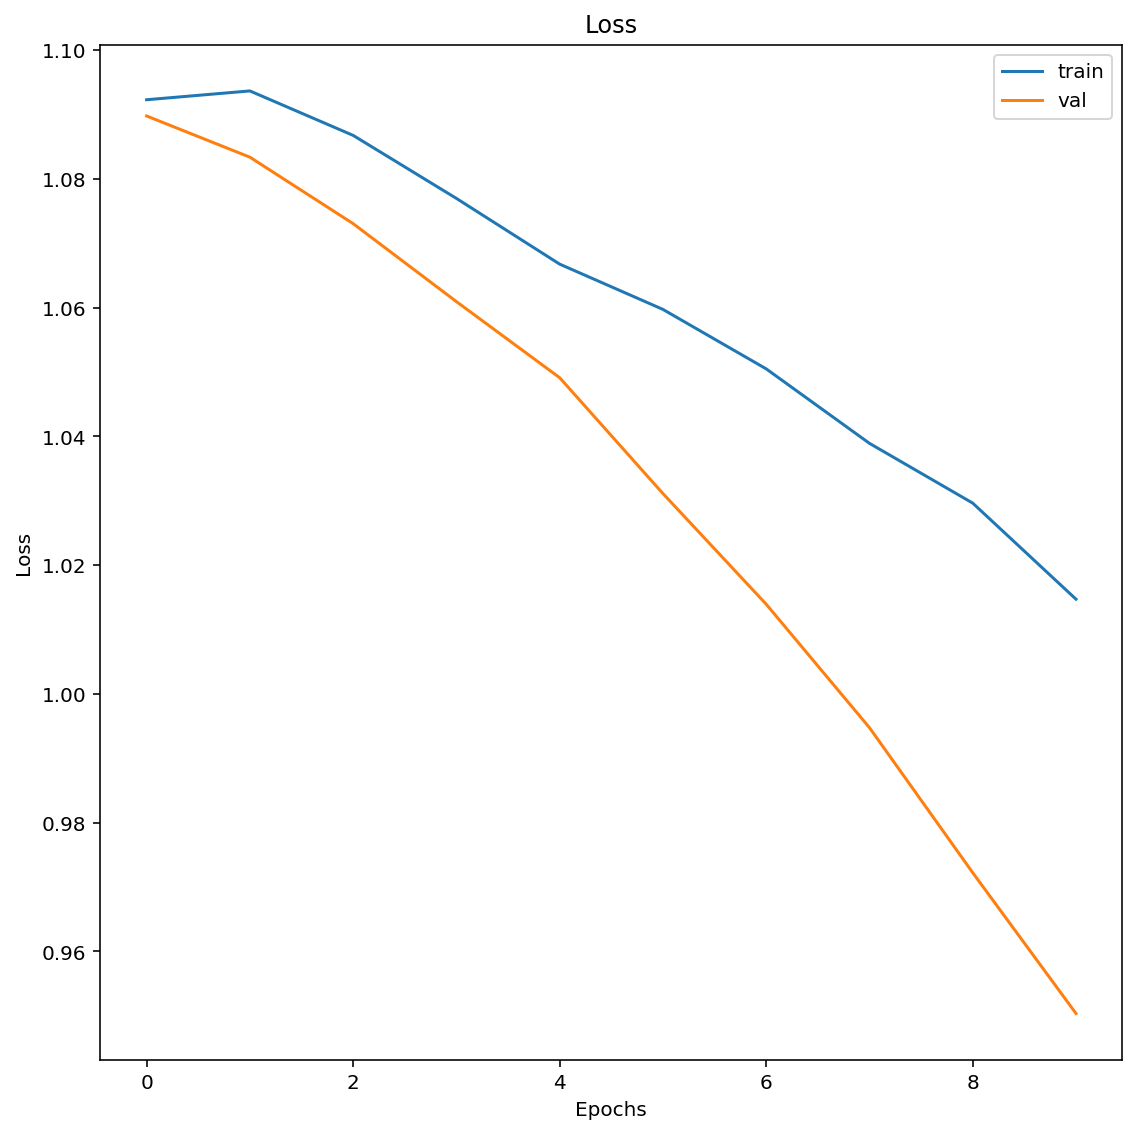

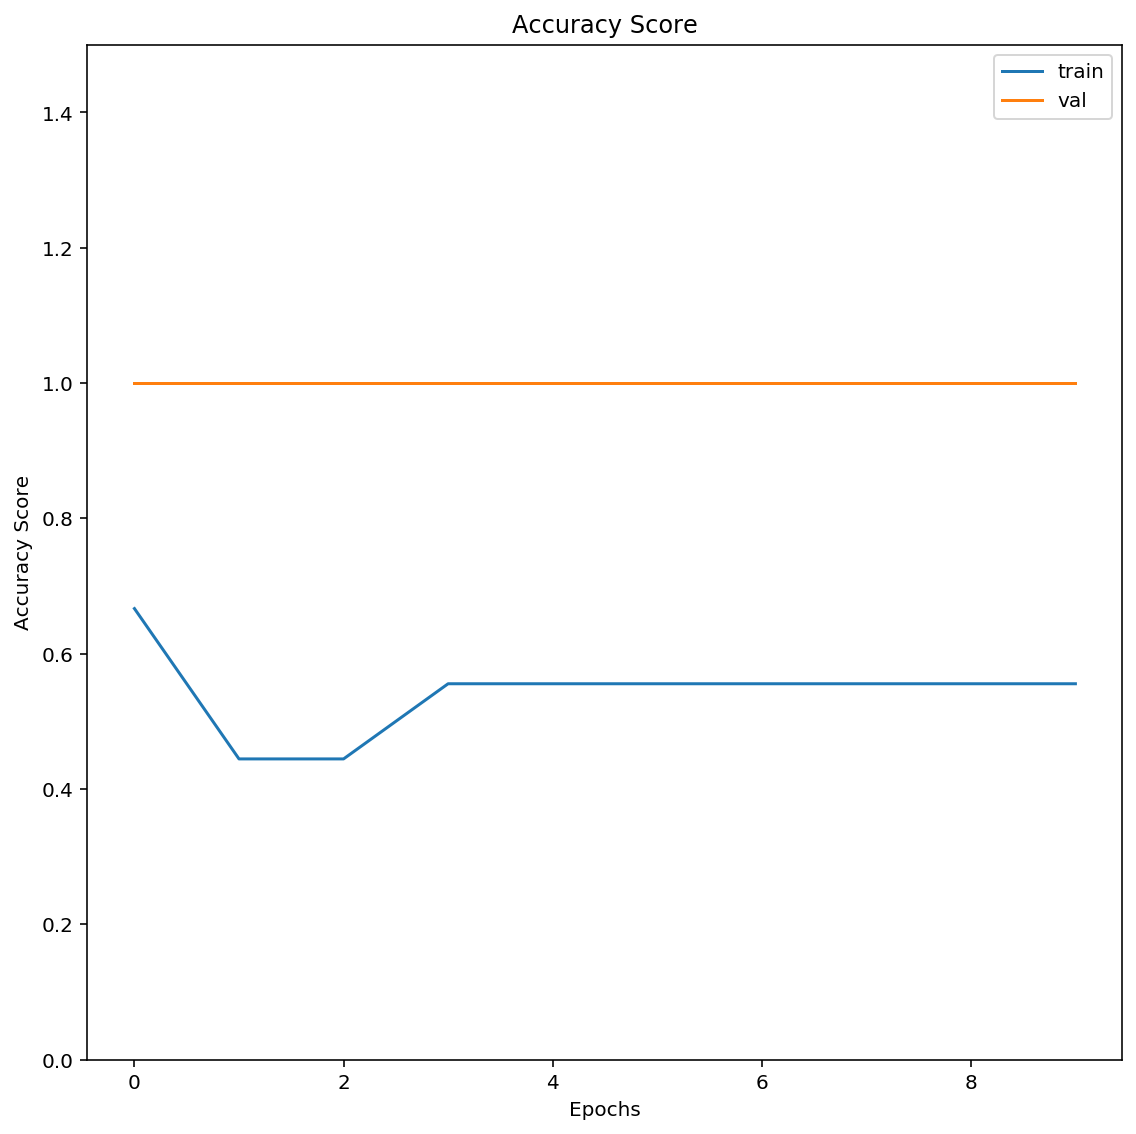

In [516]:
visualize_metrics(train_losses, val_losses, train_accuracy, val_accuracy)

In [517]:
def visualize_test(model, testloader):

    # obtain one batch of test images
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    labels_map = {0 : 'alegre', 1 : 'brabo', 2 : 'sonado'};

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        images = images.cuda()

    # get sample outputs
    output = model(images)
    
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
            
    fig = plt.figure(figsize=(8,8));
    columns = 3;
    rows = 2;
    for i in range(0, columns*rows):
        img_xy = i;
        img = images[img_xy][0]
        fig.add_subplot(rows, columns, i+1)
        plt.title(str(labels_map[int(labels[img_xy])])+" ("+labels_map[preds[i]]+")")
        plt.axis('off')
        plt.imshow(img)
    plt.show()

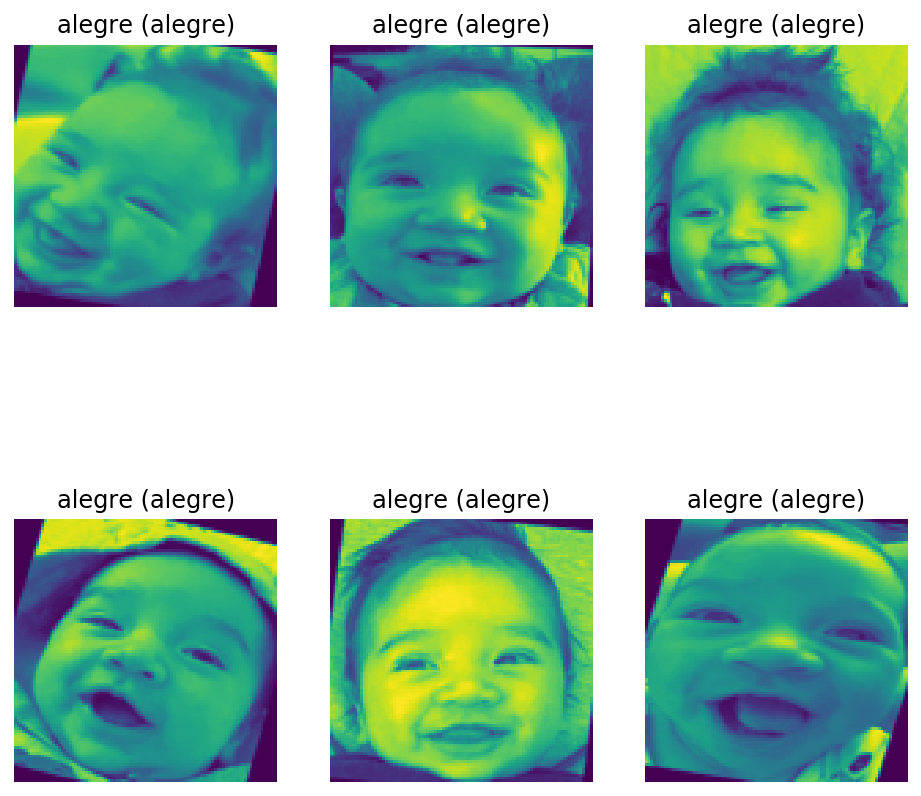

In [518]:
visualize_test(model, test_loader)

**Useful links that helped me build this notebook**

- https://discuss.pytorch.org/t/understanding-transform-normalize/21730
- https://www.jianshu.com/p/34e2ef981f9e
- https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad
- https://hackernoon.com/binary-face-classifier-using-pytorch-2d835ccb7816
- https://www.udacity.com/course/deep-learning-pytorch--ud188
- https://www.udacity.com/facebook-pytorch-scholarship
- https://github.com/udacity/deep-learning-v2-pytorch
- https://deshanadesai.github.io/notes/PyTorch